In [5]:
%pylab inline
import os.path
import cv2
import pandas as pd
import time
import json
from requests_html import HTMLSession
s = HTMLSession()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# A function to convert values from string to the most suitable format for that valuu
# - str, int or float
def mangle_type(val):
    try:
        if str(int(val)) == val.strip(): return int(val)
    except:
        pass
    try:
        if str(float(val)) == val.strip(): return float(val)
    except:
        pass
    return val

# Scraping ship position and metadata

Marine traffic stores their ship positions in JSON format in tiles that follow the TMS coordinate system.

We scrape all the tiles of the whole world for any given zoom level

In [8]:
z = 4 # Zoom level
data = {}
for x in range(0, 2**z):
    for y in range(0, 2**z):
        try:
            data["%s-%s-%s" % (z, x, y)] = s.get(
                'https://www.marinetraffic.com/getData/get_data_json_4/z:%s/X:%s/Y:%s/station:0' % (
                    z, x, y),
                cookies={"vTo": "1"}
            ).json()
        except:
            pass

In [9]:
with open("all_ships.zoom=%s.json" % z, "w") as f:
    json.dump(data, f)

Concatenate all the collected tiles and make it into a numpy "record array" - basically a table with column names and types.

In [17]:
all_ships = pd.concat([
    pd.DataFrame(
        [{key: mangle_type(val)
          for key, val in row.items()}
         for row in item['data']['rows']])
    for item in data.values()
    if 'data' in item and 'rows' in item['data'] and item['data']['rows']
]).to_records()

In [163]:
print(all_ships.dtype)
print()
print(all_ships[0])

(numpy.record, [('index', '<i8'), ('COURSE', '<i8'), ('DESTINATION', 'O'), ('DWT', '<f8'), ('ELAPSED', '<i8'), ('FLAG', 'O'), ('GT_SHIPTYPE', '<f8'), ('HEADING', '<i8'), ('LAT', '<f8'), ('LEGEND', '<f8'), ('LENGTH', '<f8'), ('LON', '<f8'), ('L_FORE', '<f8'), ('ROT', '<f8'), ('SHIPNAME', 'O'), ('SHIPTYPE', '<i8'), ('SHIP_ID', '<i8'), ('SPEED', '<i8'), ('STATUS_NAME', 'O'), ('TYPE_IMG', '<f8'), ('TYPE_NAME', 'O'), ('WIDTH', '<f8'), ('W_LEFT', '<f8')])

(0, 225, 'TUBARAO,BRAZIL', 404389., 3, 'MH', 8., 236, -20.28762, 1., 361., -40.24643, 302., 0., 'SEA BEIJING', 7, 713626, 0, nan, nan, nan, 65., 26.)


Save the data to a file so we can load it later...

In [154]:
np.savez_compressed("all_ships.zoom=4.npz", all_ships=all_ships)

# Scraping all the ship images

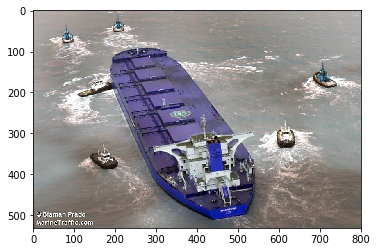

In [172]:
r = s.get("http://photos.marinetraffic.com/ais/showphoto.aspx?shipid=%s&size=" %
          all_ships[0]['SHIP_ID'])
img = cv2.imdecode(np.frombuffer(r.content, dtype=int8), cv2.IMREAD_COLOR)
plt.imshow(img)
plt.show()

Ok, so scraping one image is easy. However, when we scrape many, we risk being blocked... So, we have to sleep a bit in between...

Note that we decode the image and then encode it again (as png), just to make all images have a uniform encoding, and have an extension that matches the encoding...

In [183]:
for ship in all_ships[:5]:
    print(ship['SHIPNAME'], ship['SHIP_ID'])
    cv2.imwrite(
        "images/%s.png" % ship['SHIP_ID'],
        cv2.imdecode(
            np.frombuffer(
                s.get("http://photos.marinetraffic.com/ais/showphoto.aspx?shipid=%s&size=" %
                  ship['SHIP_ID']).content,
                dtype=int8),
            cv2.IMREAD_COLOR))
    time.sleep(5*np.random.random())

SEA BEIJING 713626
SEA FUJIYAMA 713941
SEA PONTA DA MADEIRA 4323154
[SAT-AIS] 138562632796672
[SAT-AIS] 46586786522113
